# Pasos a realizar:

- Adquirir el conjunto de datos fallo cardiaco.csv.
- Identificar la columna 13 como la etiqueta para la clasificación.
- Hacer un preprocesado de los datos.
- Separar algunos ejemplos para validar los modelos.
- Construir un modelo de clasificación binaria.
- Aprender un modelo de regresión logística bayesiana.
- Utilizar el método MCMC para el aprendizaje.
- Estimar si un nuevo paciente fallecerá o no durante el seguimiento.
- Evaluar la influencia de cada característica en el riesgo.
- Estimar la incertidumbre en los parámetros aprendidos.

In [1]:
# Parámetros globales
SEED = 42
N_SAMPLES = 6000

# Cargar el conjunto de datos `fallo_cardiaco.csv` y separar en train, val y test

In [2]:
from src.utils.io import load_data
from src.utils.split import split_data

df = load_data()
df_train, df_val, df_test = split_data(df, test_size=0.2, val_ratio=0.5, seed=SEED)

# Identificar la columna de la etiqueta y procesar los datos

In [3]:
print(f"df_train = {df_train.shape}\ndf_val = {df_val.shape}\ndf_test = {df_test.shape}\n\n")
print(df_train.info(), "\n\n")
df_train.head(5)

df_train = (239, 13)
df_val = (30, 13)
df_test = (30, 13)


<class 'pandas.core.frame.DataFrame'>
Index: 239 entries, 6 to 102
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       239 non-null    float64
 1   anaemia                   239 non-null    int64  
 2   creatinine_phosphokinase  239 non-null    int64  
 3   diabetes                  239 non-null    int64  
 4   ejection_fraction         239 non-null    int64  
 5   high_blood_pressure       239 non-null    int64  
 6   platelets                 239 non-null    float64
 7   serum_creatinine          239 non-null    float64
 8   serum_sodium              239 non-null    int64  
 9   sex                       239 non-null    int64  
 10  smoking                   239 non-null    int64  
 11  time                      239 non-null    int64  
 12  DEATH_EVENT               239 non-null    int64  
dtypes: float64

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
6,75.000,1,246,0,15,0,127000.00,1.20,137,1,0,10,1
183,75.000,0,99,0,38,1,224000.00,2.50,134,1,0,162,1
185,60.667,1,104,1,30,0,389000.00,1.50,136,1,0,171,1
146,52.000,0,132,0,30,0,218000.00,0.70,136,1,1,112,0
30,94.000,0,582,1,38,1,263358.03,1.83,134,1,0,27,1


Vemos que los datos están divididos en 13 columnas donde casi todos son biomarcadores, un valor booleano que indica si el paciente fuma o no (columna 11), el tiempo que seguimiento (columna 12) y la etiqueta, que indica si los pacientes continuaron con vida o no (columna 13). Todos son valores numéricos por lo que no va a hacer falta un procesamento de los datos en este aspecto. Vemos que no hay datos faltantes ya que todas las columnas cuentan con valores en los 299 ejemplos por lo que normalizamos los datos antes de entrenarlos.

# Entrenar un modelo de regresión logística bayesiana

In [5]:
from src.models.bayesian_logistics import BayesianLogisticRegression
from src.utils.split import split_col
from src.utils.preprocesing import fit_scaler, apply_scaler


X_train, y_train = split_col(df_train, col_name="DEATH_EVENT")
X_val, y_val = split_col(df_val, col_name="DEATH_EVENT")
scaler, X_train_norm = fit_scaler(X_train=X_train)
X_val_norm = apply_scaler(scaler=scaler, X=X_val)

# Definición y entrenamiento de modelo lineal
model = BayesianLogisticRegression(num_samples=N_SAMPLES, step_size=0.02, burn_in=1000, seed=SEED)
model.fit(X_train_norm, y_train)

# Predicción
probs = model.predict_proba(X_val_norm)
preds = model.predict(X_val_norm)
print("Probabilidades de la predicción:", probs)
print("Predicciones de validación:", preds)

# Análisis de incertidumbre
summary = model.summary()
print("Media de coeficientes:", summary["mean"])
print("Desviación estándar:", summary["std"])


Probabilidades de la predicción: [0.12810134 0.21022426 0.81264052 0.61626036 0.33242316 0.86492426
 0.05034977 0.97092918 0.37398771 0.07544425 0.90254408 0.03781846
 0.77134818 0.40762573 0.15157475 0.25316963 0.626948   0.80038027
 0.09844576 0.45014002 0.59905631 0.4336914  0.93646681 0.71524058
 0.47527871 0.30298503 0.49602948 0.38315551 0.08767228 0.57221048]
Predicciones de validación: [0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1]
Media de coeficientes: [ 0.53418667 -0.07765263  0.16568159  0.08465705 -0.6648261  -0.0370559
 -0.01573521  1.21045994 -0.13293442 -0.30624954  0.06753198 -1.38190325]
Desviación estándar: [0.22989088 0.17585224 0.17331467 0.23016206 0.17428724 0.1746474
 0.17853717 0.46751055 0.16473334 0.15973041 0.1288393  0.18969308]


## Visualización de la influencia

In [9]:
summary = model.summary()
mean = summary["mean"]
std = summary["std"]

feature_names = df_train.drop(columns=["DEATH_EVENT"]).columns

for name, m, s in zip(feature_names, mean, std):
    print(f"{name}: media = {m:.3f}, desviación = {s:.3f}")


age: media = 0.534, desviación = 0.230
anaemia: media = -0.078, desviación = 0.176
creatinine_phosphokinase: media = 0.166, desviación = 0.173
diabetes: media = 0.085, desviación = 0.230
ejection_fraction: media = -0.665, desviación = 0.174
high_blood_pressure: media = -0.037, desviación = 0.175
platelets: media = -0.016, desviación = 0.179
serum_creatinine: media = 1.210, desviación = 0.468
serum_sodium: media = -0.133, desviación = 0.165
sex: media = -0.306, desviación = 0.160
smoking: media = 0.068, desviación = 0.129
time: media = -1.382, desviación = 0.190


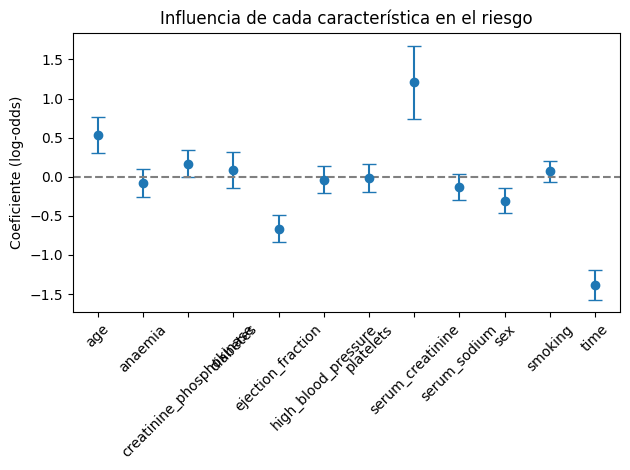

In [11]:
import matplotlib.pyplot as plt

plt.errorbar(feature_names, mean, yerr=std, fmt='o', capsize=5)
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=45)
plt.title("Influencia de cada característica en el riesgo")
plt.ylabel("Coeficiente (log-odds)")
plt.tight_layout()
plt.show()


In [13]:
import numpy as np

lower = np.percentile(model.samples_, 2.5, axis=0)
upper = np.percentile(model.samples_, 97.5, axis=0)

for name, l, u in zip(feature_names, lower, upper):
    print(f"{name}: intervalo 95% = [{l:.3f}, {u:.3f}]")


age: intervalo 95% = [0.037, 0.963]
anaemia: intervalo 95% = [-0.450, 0.242]
creatinine_phosphokinase: intervalo 95% = [-0.147, 0.540]
diabetes: intervalo 95% = [-0.374, 0.493]
ejection_fraction: intervalo 95% = [-0.974, -0.343]
high_blood_pressure: intervalo 95% = [-0.424, 0.283]
platelets: intervalo 95% = [-0.355, 0.294]
serum_creatinine: intervalo 95% = [0.612, 2.295]
serum_sodium: intervalo 95% = [-0.459, 0.158]
sex: intervalo 95% = [-0.621, 0.019]
smoking: intervalo 95% = [-0.218, 0.281]
time: intervalo 95% = [-1.736, -1.021]
